In [65]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

In [66]:
dfo = pd.read_excel('data.xlsx')


In [67]:
filtered_s2k = [col for col in dfo.columns if 'S2K_item_' in col][:24]
# filtered_sdi = [col for col in dfo.columns if 'New_SDI_since_previous_visit' in col]

filtered_columns = []

filtered_columns.append(dfo.SLET2T_ID.name)
filtered_columns.append(dfo.Visit_month_new.name)
filtered_columns.extend(filtered_s2k)
# filtered_columns.append(dfo.SDI.name)
filtered_columns.append(dfo.New_SDI_since_previous_visit_new.name)


In [68]:
df = dfo[filtered_columns]
df.columns

Index(['SLET2T_ID', 'Visit_month_new', 'S2K_item_1', 'S2K_item_2',
       'S2K_item_3', 'S2K_item_4', 'S2K_item_5', 'S2K_item_6', 'S2K_item_7',
       'S2K_item_8', 'S2K_item_9', 'S2K_item_10', 'S2K_item_11', 'S2K_item_12',
       'S2K_item_13', 'S2K_item_14', 'S2K_item_15', 'S2K_item_16',
       'S2K_item_17', 'S2K_item_18', 'S2K_item_19', 'S2K_item_20',
       'S2K_item_21', 'S2K_item_22', 'S2K_item_23', 'S2K_item_24',
       'New_SDI_since_previous_visit_new'],
      dtype='object')

In [69]:
df.New_SDI_since_previous_visit_new.fillna(0, inplace=True)

C:\Users\gsevr\AppData\Local\Temp\ipykernel_250724\1029583041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.New_SDI_since_previous_visit_new.fillna(0, inplace=True)


In [70]:
ids = []
for id in df.SLET2T_ID.unique():
    if any(df[df.SLET2T_ID == id].New_SDI_since_previous_visit_new) != 0:
        ids.append(id)

In [71]:
print(len(df.SLET2T_ID.unique()))
print(len(ids))

354
99


In [73]:
# The reasoning here is that the patients history up to the first occurence of SDI > 0 can be used to predict that prognosis
dfs = []

for id in ids:
    df_id = df[df.SLET2T_ID == id]
    
    first_occurrence = df_id[df_id.New_SDI_since_previous_visit_new == 1].index.min()
    
    if first_occurrence is not None:
        df_filtered = df_id.loc[:first_occurrence]
    else:
        df_filtered = df_id
    
    dfs.append(df_filtered)



In [76]:
max_shape = dfs[0].shape[0]
max_index = 0

for index, df in enumerate(dfs):
    if df.shape[0] > max_shape:
        max_shape = df.shape[0]
        max_index = index

print(f'Max shape: {max_shape}\nIndex: {max_index}')


Max shape: 12
Index: 13


In [78]:
padded_dfs = []

for df in dfs:

    padding = 12 - df.shape[0]
    if padding > 0:
        zeros_df = pd.DataFrame(0, index=np.arange(padding), columns=df.columns)

        padded_df = pd.concat([zeros_df, df], ignore_index=True)

    else:
        padded_df = df

    padded_dfs.append(padded_df)

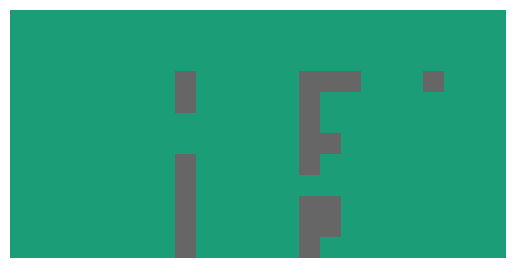

In [117]:
plt.imshow(X[5],cmap='Dark2')
plt.axis('off')
plt.show()

In [85]:
X = []

for df in padded_dfs:
    X.append(df.iloc[:,2:-1])

In [88]:
X_train = np.array(X)

In [94]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the dimensions of the input image
input_shape = (12, 24, 1)  # Example for a grayscale image of size 12x24

# Encoder
encoder_input = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Output: (6, 12, 32)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Output: (3, 6, 64)
encoded = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = layers.UpSampling2D((2, 2))(encoded)  # Output: (6, 12, 128)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # Output: (12, 24, 64)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Output: (12, 24, 1)

# Autoencoder model
autoencoder = models.Model(encoder_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Summary of the model
autoencoder.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 12, 24, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 12, 24, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 6, 12, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 6, 12, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 3, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 3, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 6, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 6, 12, 64)      │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 12, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 12, 24, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 12, 24, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,217 (723.50 KB)

 Trainable params: 185,217 (723.50 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=16)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2120
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0397 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0326 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0341 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0339 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0337 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0317 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0345 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0334 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0344
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0351 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0353 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0332 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0336 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0327 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━

Text(0, 0.5, 'loss')

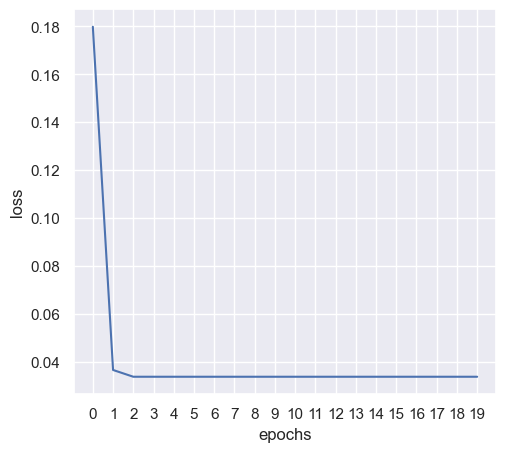

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.xticks([i for i in range(0,20)])
plt.xlabel('epochs')
plt.ylabel('loss')
